# NYC Taxi Data Exploration



This notebook explores the NYC Taxi and Limousine Commision Trip Record Data to understand patterns and prepare it for the Dynamic Pricing Simulator Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Import data loader
import sys
sys.path.append('..')
from src.data.data_loader import load_taxi_data, save_processed_data
from src.data.preprocessing import add_time_features, add_pricing_features

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Loading and Examining the Data

In [2]:
# Load one month of data
df = load_taxi_data('../data/raw/yellow_tripdata_2022-01.parquet', sample_size=None)

Loading data from ../data/raw/yellow_tripdata_2022-01.parquet...
Loaded 2463931 rows
Performing basic cleaning...
2290825 rows after cleaning


In [3]:
# Display basic information
print(f"Data shape: {df.shape}")
df.head()

Data shape: (2290825, 22)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_datetime,dropoff_datetime,trip_duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,...,0.5,3.65,0.0,0.3,21.95,2.5,0.0,2022-01-01 00:35:40,2022-01-01 00:53:29,17.816667
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,...,0.5,4.00,0.0,0.3,13.30,0.0,0.0,2022-01-01 00:33:43,2022-01-01 00:42:07,8.400000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,...,0.5,1.76,0.0,0.3,10.56,0.0,0.0,2022-01-01 00:53:21,2022-01-01 01:02:19,8.966667
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,...,0.5,0.00,0.0,0.3,11.80,2.5,0.0,2022-01-01 00:25:21,2022-01-01 00:35:23,10.033333
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,...,0.5,3.00,0.0,0.3,30.30,2.5,0.0,2022-01-01 00:36:48,2022-01-01 01:14:20,37.533333


In [4]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2290825 entries, 0 to 2392427
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

In [5]:
# Summary statistics
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_datetime,dropoff_datetime,trip_duration
count,2.290825e+06,2290825,2290825,2.290825e+06,2.290825e+06,2.290825e+06,2.290825e+06,2.290825e+06,2.290825e+06,2.290825e+06,...,2.290825e+06,2.290825e+06,2.290825e+06,2.290825e+06,2.290825e+06,2.290825e+06,2.290825e+06,2290825,2290825,2.290825e+06
mean,1.712095e+00,2022-01-17 00:47:31.641720,2022-01-17 01:00:17.205516,1.422282e+00,3.142739e+00,1.346851e+00,1.661027e+02,1.637630e+02,1.212746e+00,1.259382e+01,...,4.983742e-01,2.383479e+00,3.732391e-01,2.999920e-01,1.888420e+01,2.325267e+00,8.339354e-02,2022-01-17 00:47:31.641720,2022-01-17 01:00:17.205516,1.275940e+01
min,1.000000e+00,2021-12-31 23:56:26,2022-01-01 00:02:27,1.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e+00,0.000000e+00,0.000000e+00,2021-12-31 23:56:26,2022-01-01 00:02:27,1.016667e+00
25%,1.000000e+00,2022-01-09 15:02:45,2022-01-09 15:15:16,1.000000e+00,1.070000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,...,5.000000e-01,1.000000e+00,0.000000e+00,3.000000e-01,1.130000e+01,2.500000e+00,0.000000e+00,2022-01-09 15:02:45,2022-01-09 15:15:16,6.416667e+00
50%,2.000000e+00,2022-01-17 10:52:03,2022-01-17 11:03:16,1.000000e+00,1.760000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,...,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,1.430000e+01,2.500000e+00,0.000000e+00,2022-01-17 10:52:03,2022-01-17 11:03:16,1.018333e+01
75%,2.000000e+00,2022-01-24 12:26:04,2022-01-24 12:38:13,1.000000e+00,3.120000e+00,1.000000e+00,2.340000e+02,2.360000e+02,1.000000e+00,1.350000e+01,...,5.000000e-01,3.000000e+00,0.000000e+00,3.000000e-01,1.971000e+01,2.500000e+00,0.000000e+00,2022-01-24 12:26:04,2022-01-24 12:38:13,1.606667e+01
max,2.000000e+00,2022-05-18 20:41:57,2022-05-18 20:47:45,9.000000e+00,9.920000e+01,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,1.995000e+02,...,3.300000e+00,8.888800e+02,1.933000e+02,3.000000e-01,8.996800e+02,2.500000e+00,1.250000e+00,2022-05-18 20:41:57,2022-05-18 20:47:45,1.796500e+02
std,4.527865e-01,NaN,NaN,9.744095e-01,4.071932e+00,5.469928e+00,6.503964e+01,7.065234e+01,4.224247e-01,1.125678e+01,...,2.853510e-02,2.722699e+00,1.651706e+00,1.548048e-03,1.412253e+01,6.374163e-01,3.119094e-01,NaN,NaN,9.537537e+00


## 2. Data Preprocessing

In [6]:
# Add time-based features
df = add_time_features(df)

# Add pricing features
df = add_pricing_features(df)

# Check new features
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,hour,day_of_week,day,month,year,is_weekend,is_rush_hour,time_of_day,price_per_mile,price_per_minute
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,...,0,5,1,1,2022,True,False,night,3.815789,0.813845
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,...,0,5,1,1,2022,True,False,night,3.809524,0.952381
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,...,0,5,1,1,2022,True,False,night,7.731959,0.836431
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,...,0,5,1,1,2022,True,False,night,7.339450,0.797342
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,...,0,5,1,1,2022,True,False,night,5.465116,0.626110


## 3. Exploratory Data Analysis

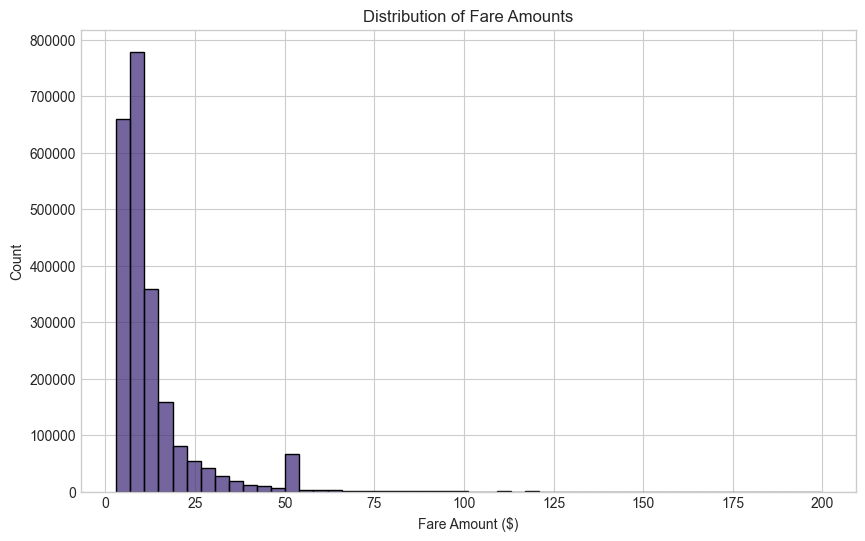

In [7]:
# Distribution of fares
plt.figure(figsize=(10,6))
sns.histplot(df['fare_amount'], bins=50)
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Count')
plt.show()

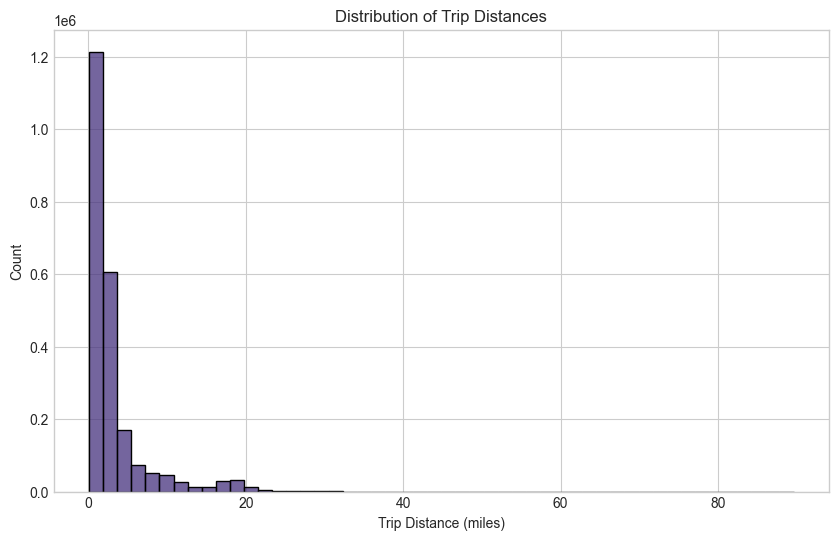

In [8]:
# Distribution of trip distances
plt.figure(figsize=(10,6))
sns.histplot(df['trip_distance'], bins=50)
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Count')
plt.show()

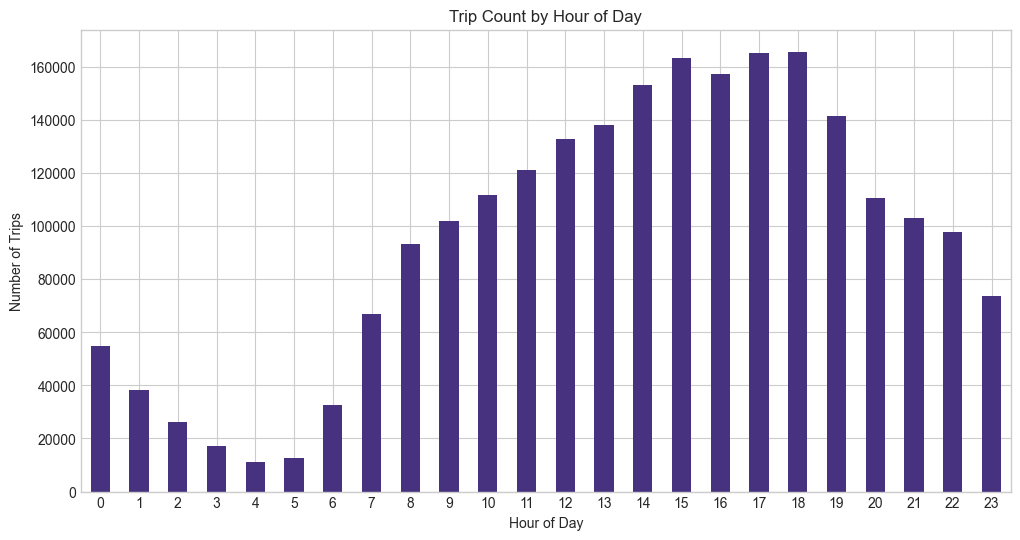

In [9]:
# Trip count by hour of day
hourly_counts = df.groupby('hour')['pickup_datetime'].count()

plt.figure(figsize=(12,6))
hourly_counts.plot(kind='bar')
plt.title('Trip Count by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()

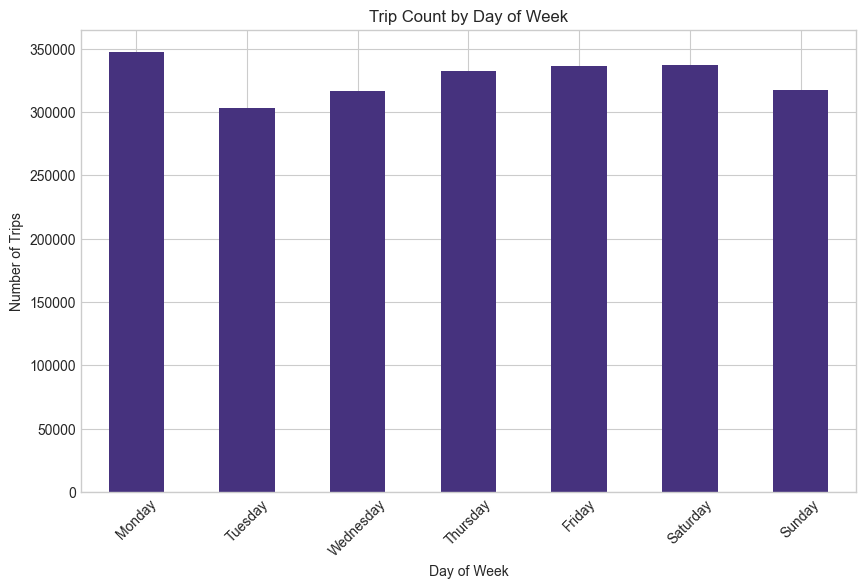

In [10]:
# Trip count by day of week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_counts = df.groupby('day_of_week')['pickup_datetime'].count()

plt.figure(figsize=(10,6))
daily_counts.plot(kind='bar')
plt.title('Trip Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.xticks(range(7),days,rotation=45)
plt.show()

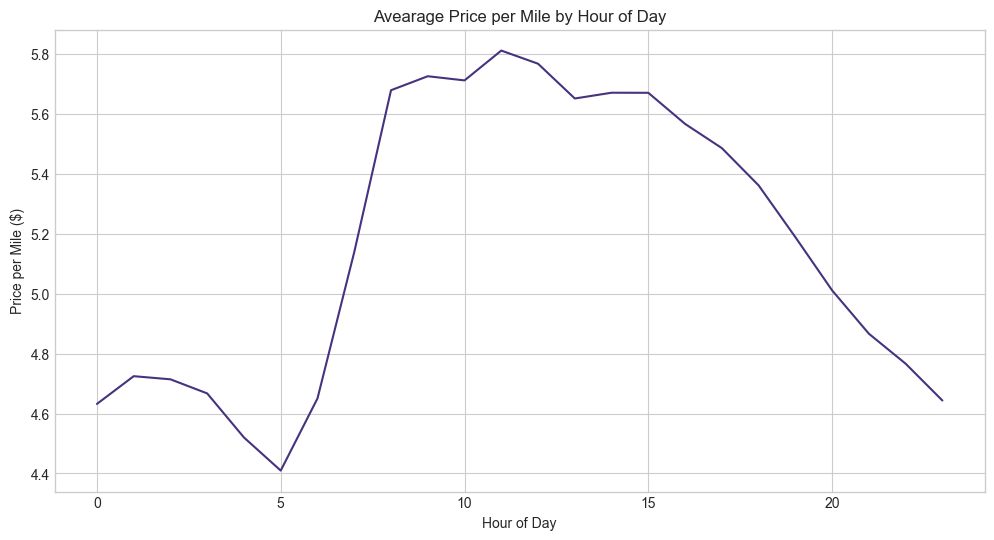

In [11]:
# Price per mile by hour of day
hourly_price_per_mile = df.groupby('hour')['price_per_mile'].mean()

plt.figure(figsize=(12,6))
hourly_price_per_mile.plot()
plt.title('Avearage Price per Mile by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Price per Mile ($)')
plt.grid(True)
plt.show()

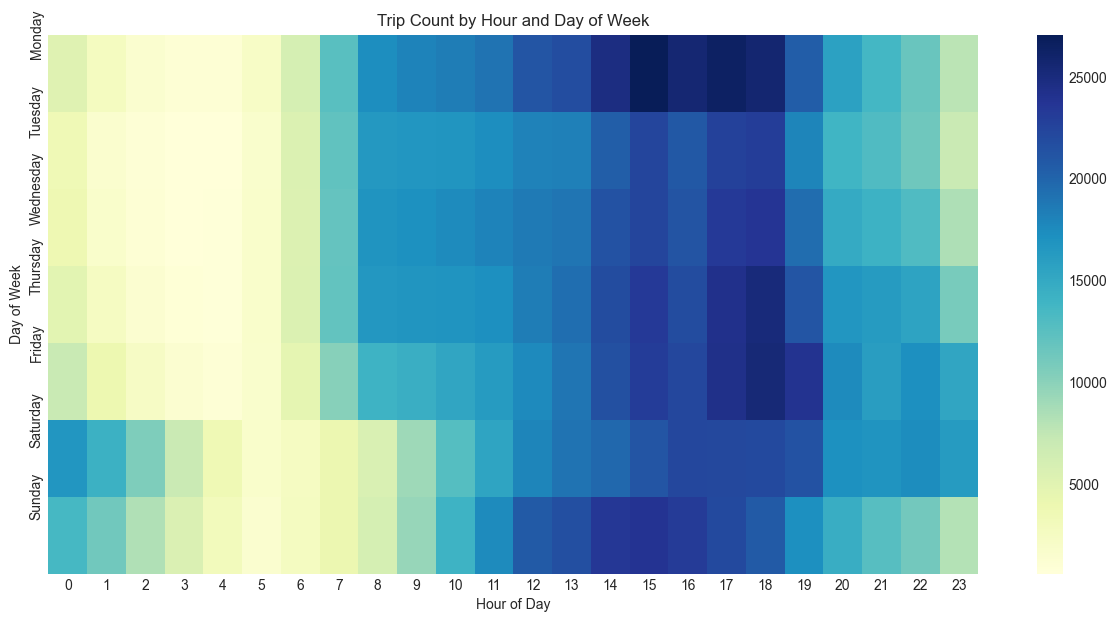

In [12]:
# Heat Map of Trip Count by Hour of Day
hourly_daily_counts = df.groupby(['day_of_week','hour'])['pickup_datetime'].count().reset_index()
hourly_daily_pivot = hourly_daily_counts.pivot(index='day_of_week', columns='hour', values='pickup_datetime')

plt.figure(figsize=(15,7))
sns.heatmap(hourly_daily_pivot, cmap='YlGnBu')
plt.title('Trip Count by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(range(7),days)
plt.show()

## 4. Relationship Between Price and Demand

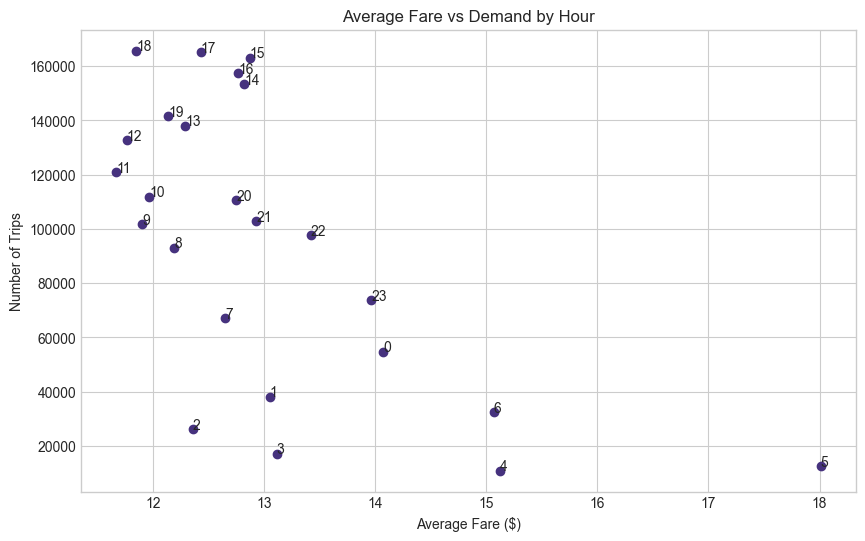

In [13]:
# Group by hour and calculate average fare and demand
hourly_stats = df.groupby('hour').agg({
    'fare_amount':'mean',
    'pickup_datetime':'count'
}).rename(columns={'pickup_datetime':'demand'})

# Scatter plot of price vs demand
plt.figure(figsize=(10,6))
plt.scatter(hourly_stats['fare_amount'],hourly_stats['demand'])

# Add hour labels to points
for i, txt in enumerate(hourly_stats.index):
    plt.annotate(txt, (hourly_stats['fare_amount'].iloc[i],hourly_stats['demand'].iloc[i]))

plt.title('Average Fare vs Demand by Hour')
plt.xlabel('Average Fare ($)')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

c:\Projects\Dynamic-Pricing-Simulator-Project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


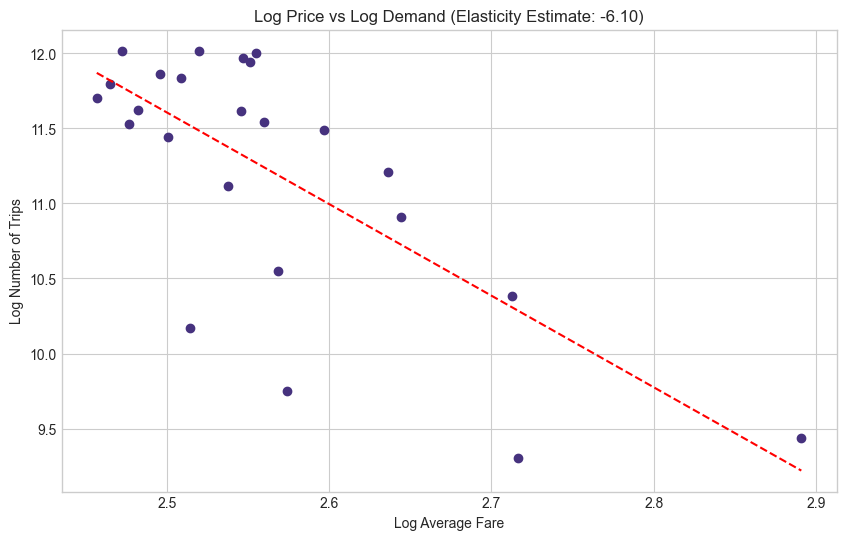

In [14]:
# Calculate log values for elasticity estimation
hourly_stats['log_price'] = np.log(hourly_stats['fare_amount'])
hourly_stats['log_demand'] = np.log(hourly_stats['demand'])

# plot log-log relationship
plt.figure(figsize=(10,6))
plt.scatter(hourly_stats['log_price'], hourly_stats['log_demand'])

# Linear regression for elasticity estimate
model = LinearRegression()
X = hourly_stats[['log_price']]
y = hourly_stats['log_demand']
model.fit(X,y)

# Plot Regression Line
x_range = np.linspace(X.min(),X.max(),100)
y_pred = model.predict(x_range.reshape(-1,1))
plt.plot(x_range, y_pred, 'r--')

plt.title(f'Log Price vs Log Demand (Elasticity Estimate: {model.coef_[0]:.2f})')
plt.xlabel('Log Average Fare')
plt.ylabel('Log Number of Trips')
plt.grid(True)
plt.show()

## 5. Save Processed Data

In [15]:
# Save processed data for further analysis

save_processed_data(df, 'processed_taxi_data.csv', '../data/processed')

Saved processed data to ../data/processed/processed_taxi_data.csv


## 6. Conclusions

1. Majority of trips are short and inexpensive.
2. The trip demand exibits noticeable peaks around 3PM, 5PM and 6PM
3. Monday experiences the highest number of trips, while Tuesday has the lowest demand.
4. Taxi company reduces fares during peak hours (such as 3 PM - 6 PM) to attract more passengers despite the high demand.
5. Rush hours (morning and evening) drive the highest demand, suggesting an opportunity for dynamic pricing strategies.
6. Late-night demand is significantly lower, indicating a reduced need for fleet availability.
7. Weekend travel patterns differ, with Saturday morning trips being higher, likely due to social events or leisure activities.
8. The elasticity estimate of -6.10 reveals that taxi riders are very sensitive to price changes.  A small fare increase could lead to a significant drop in demand, meaning fewer people will choose to take taxis. This suggests that the company needs to be cautious about raising prices, as it could negatively impact their revenue.

